## BMI 776: Computation Network Biology 

### Network properties & clustering on networks 
##### October 17th lecture notes
##### Erika Da-Inn Lee, Spencer Halberg-Spencer 

Today's lecture material will on the following material: 
1. Degree distributions of graphs
2. Graph clustering 
    1. Hierarchical clustering 
    2. Louvain clustering
    3. Spectral clustering
3. Quantify graph cluster quality using  both node and graph quantities.   

This jupyter notebook will act as an aid and explination of each of these learning objectives. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import scipy as sp
from sklearn.cluster import KMeans
import math
import igraph as ig
import pandas as pd
from ipywidgets import interact, IntSlider, FloatSlider, interactive
from IPython.display import display, HTML

### Degree Distributions

Our first learning objective is to explore the degree distributions of graphs. Recall, that the node degree distribution is defined as followed: 
* Undirected network: For a node $i$, the degree is defined as the number of edges that connect $i$ to a neighbor, $j$. More susciently, the degree of node $i$ is the number of edges connected to node $i$. 
* Directed network: Remember we consider sets of edges are ordered for directed graph, such that a edge $<i,j>$ represents and edge that is outgoing from node i and incoming to node j. We can consider two values for directed networks. 
    * In degree: For node j, it is the number of edges that are incoming to node j. 
    * Out degree: For node i, it is the number of edges that are outgoing from node i. 

We can quantify global properperties of the graph that relate to degree. The most straightforward measure of the connectiveness of a graph is the average degree. Consider an undirected graph with $N$ nodes. Let $k_i$ denote the degree of node $i$. The average degree is: 

$$<k> = \frac{\sum_{i=1}^{N} k_i}{N}$$ 

While this measure gives a simple way of comparing graphs, it does not give an indication of the variability of degree among edges within a single network. This variability is an important property of graphs, especially when trying to identify nodes which are highly connected. Instead, we can consider the *degree distribution*. 

* Degree distribution : The probability P(k), that a node has k edges. Generally this is computed empirically for a given graph.

We can compare the distribution between graphs to get a better understanding of how edges are connected globally.  Today we will cover two improtant degree distributions: the poisson distribution and the power law (scale-free distribution). 

### Poisson distributions and Erdos-Renyi Graphs
The poisson distribution is a descete distribution parameterized by the following equations: 

$$ P( X = k ) = \frac{\lambda^{k}e^{-\lambda}}{k!}$$  

A few important points about the poisson distribution and graph degree: 
* $\lambda$ represents the expected value of $X$, as well as the variance of $X$. 
* We can estimate $\lambda$ using the maximum likelihood estimator, which is equivelent to the average node degree, $\lambda_{MLE} = \frac{\sum_{i=1}^{N} k_i}{N}$
* The MLE estimator of $\lambda$ is an unbiased estimator of $\lambda$. This works well when N is sufficiently large.   


An *Erdos-Renyi graph* is a graph that is generated using a probalilistic generation process. Consider $N$ nodes, the model is specified by the probability tyhat a given two nodes, an edge exists between these nodes with probability, $p$. These graphs have Poisson degree distributions.

The Erdos-Renyi graph generation models is implemented in the igraph package. We will be useing the following implementation *ig.Graph.Erdos_Renyi(n, p, directed, loops)*. This implementation takes in the following parameters: 
1. n: The number of nodes in the graph. 
2. p: the probability that an edge exists between any two nodes. The probability of a given edges is indepedent of all other edges. 
3. directed: A boolean indicating if we want an directed or undirected graph. (default = False). 
4. loops: If we want the graph to include edges that exist between a single node, eg (i, i). (default = False). 

In the next code block, I generated four different graphs with 30 nodes, and varying probabilities of an edge.

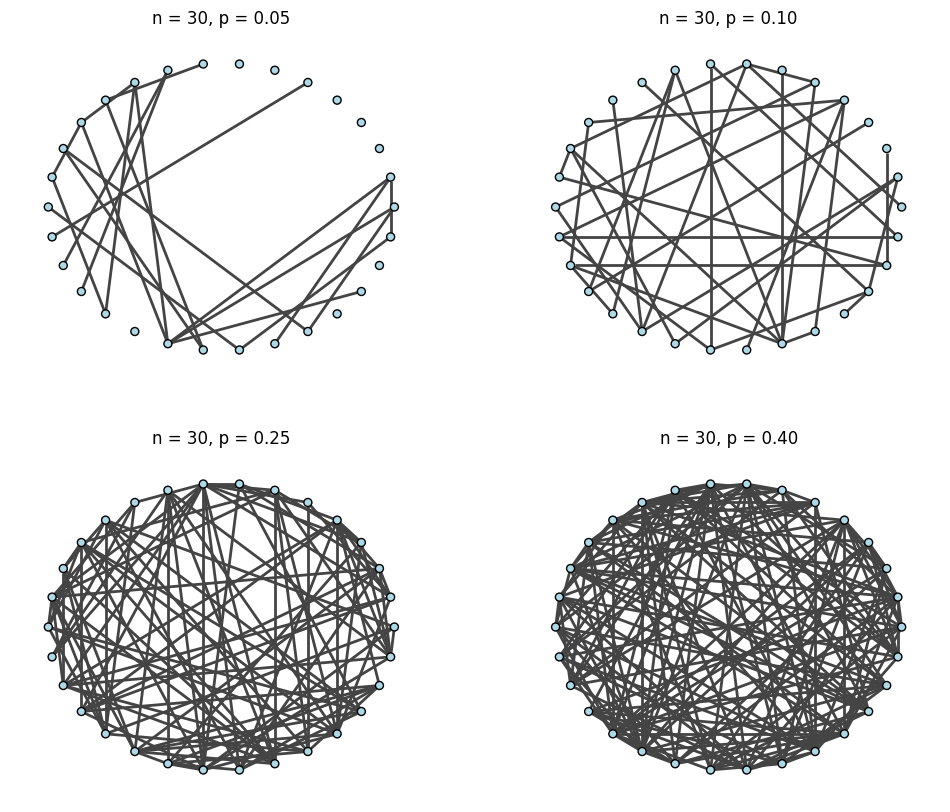

In [2]:
g1 = ig.Graph.Erdos_Renyi(n = 30, p = 0.05, directed = False, loops = False)
g2 = ig.Graph.Erdos_Renyi(n = 30, p = 0.10, directed = False, loops = False)
g3 = ig.Graph.Erdos_Renyi(n = 30, p = 0.25, directed = False, loops = False)
g4 = ig.Graph.Erdos_Renyi(n = 30, p = 0.40, directed = False, loops = False)



fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
axs[0, 0].set_title('n = 30, p = 0.05')
axs[0, 1].set_title('n = 30, p = 0.10')
axs[1, 0].set_title('n = 30, p = 0.25')
axs[1, 1].set_title('n = 30, p = 0.40')

ig.plot(
    g1,
    target=axs[0, 0],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)

ig.plot(
    g2,
    target=axs[0, 1],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)

ig.plot(
    g3,
    target=axs[1, 0],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)

ig.plot(
    g4,
    target=axs[1, 1],
    layout="circle",
    vertex_color="lightblue", 
    vertex_size = 8
)
plt.show()

We can explore distribution of each plot using the plot_degree_dist function below. This function takes in an igraph object and generates a normalized histogram which displays the probability of observing a node with degree i. This distribution is estimated empirically for each graph. 

We can compare the emipirically estimated distribution to the estimated poisson distribution for each graph. The promobability mass function for the poisson distribution can be added to aplot using the plot_poisson function below. 

In [3]:
### Define a function that plots the degree distribution for a given graph. 
def plot_degree_dist(igraph_obj):
    degree = igraph_obj.degree() 
    ### Give a vector which denotes the degree of each node. 
    plt.hist(degree, [ x - 0.5 for x in range(0, max(degree) + 2, 1)], density = True, color = 'black') ## Make bins surronding each integer and count the number of nodes with each degree.
    plt.xlim(right = max(degree)+ 0.5 )
    if(max(degree) <= 10):    
        plt.xticks([x for x in range(0, max(degree)+1)])  ## With small degree, we can enumerate all values on axis. 
        
### Define a function that plots the poisson probability mass function (the equation from above)
def plot_poisson(l, max_disp):
    x  = np.arange(0, max_disp+1)
    ## Computed by hand so you can see how. Math fact, will overflow for relatively small k so we need to also include the a call to the stats package. 
    if(max_disp <= 50):
        prob = [(l**k) * np.exp(-l) / math.factorial(k) for k in x]
        plt.plot(x, prob, 'rx--') ### Plot the poisson distribution 
    else:
        ## This also just computes the poisson probability distribution but we don't worry about overflow. 
        prob = sp.stats.poisson.pmf(x, mu = l)   
        plt.plot(x, prob, 'r--')
    
            

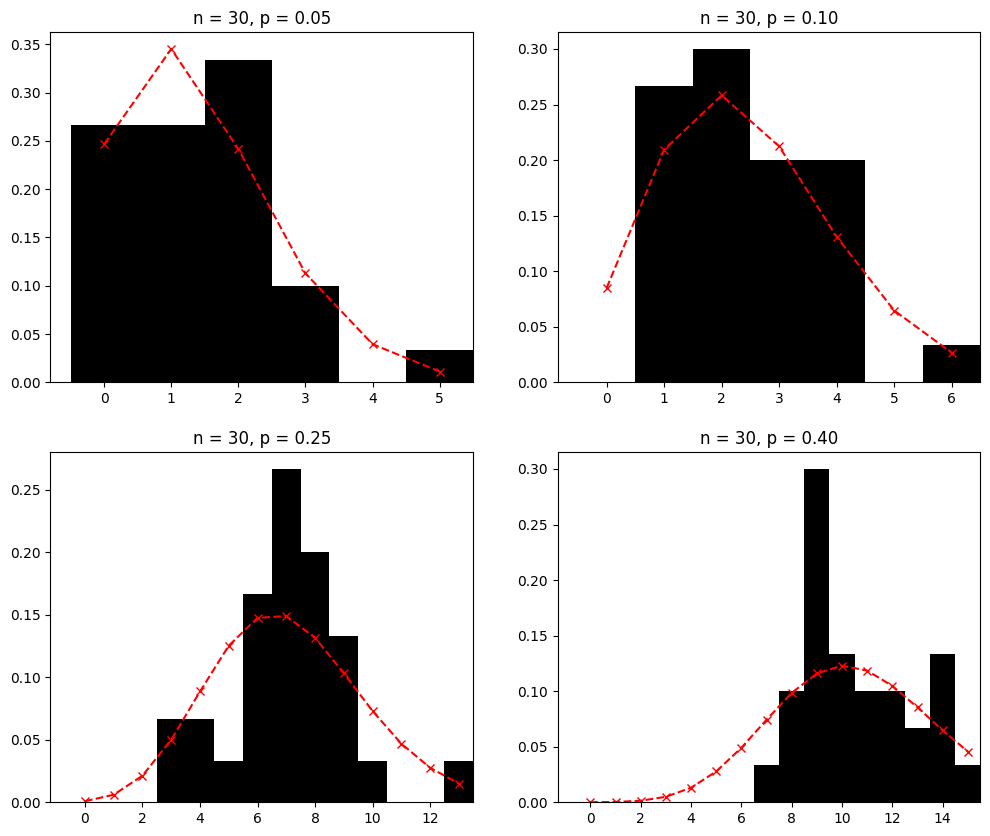

In [4]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
plt.sca(axs[0,0]) ## Set active plot 
axs[0,0].set_title('n = 30, p = 0.05')
plot_degree_dist(g1)
plot_poisson(np.mean(g1.degree()), max(g1.degree()))


plt.sca(axs[0,1]) ## Set active plot 
axs[0, 1].set_title('n = 30, p = 0.10')
plot_degree_dist(g2)
plot_poisson(np.mean(g2.degree()), max(g2.degree()))


plt.sca(axs[1,0]) ## Set active plot 
axs[1, 0].set_title('n = 30, p = 0.25')
plot_degree_dist(g3)
plot_poisson(np.mean(g3.degree()), max(g3.degree()))

plt.sca(axs[1,1]) ## Set active plot 
axs[1, 1].set_title('n = 30, p = 0.40')
plot_degree_dist(g4)
plot_poisson(np.mean(g4.degree()), max(g4.degree()))

In [5]:

# Function to generate Erdos-Renyi graph and plot results
def plot_erdos_renyi_graph(n, p):
    # Generate a random Erdos-Renyi graph
    graph = ig.Graph.Erdos_Renyi(n=n, p=p)

    # Get degree distribution
    degrees = graph.degree()
    mean_degree = np.mean(degrees)

    # Plot the graph
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 10)

    # Plot 1: Graph visualization
    ig.plot(graph, target=axs[0], vertex_size=3, edgewidth = 0.15,  layout='kk')
    plt.title("Erdos-Renyi Graph")

    # Plot 2: Histogram of node degree distribution and Poisson distribution
    plt.sca(axs[1]) ## Set active plot 
    plt.hist(degrees, bins=np.arange(min(degrees)-.5, max(degrees) + 1.5, 1), density=True, alpha=0.6, color='b', label='Degree Distribution')

    # Poisson distribution with lambda = mean degree
    poisson_dist = sp.stats.poisson.pmf(np.arange(0, max(degrees) + 1), mu = mean_degree)  
    
    plt.plot(np.arange(0, max(degrees) + 1), poisson_dist, 'r-', lw=2, label=f'Poisson(λ={mean_degree:.2f})')

    plt.title('Degree Distribution with Poisson Fit')
    plt.xlabel('Degree')
    plt.ylabel('Probability')
    plt.legend()

    plt.tight_layout()
    plt.show()

interact(plot_erdos_renyi_graph, 
         n=IntSlider(min=30, max=500, step=10, value=100, description='Number of Nodes'),
         p=FloatSlider(min=0.01, max=.99, step=0.01, value=0.05, description='Edge Probability'))



interactive(children=(IntSlider(value=100, description='Number of Nodes', max=500, min=30, step=10), FloatSlid…

<function __main__.plot_erdos_renyi_graph(n, p)>

<div style="background-color: lightblue; padding: 10px;">

#### Questions

1. In Erodos Renyi Graph generation process, each edge is modeled as a binomial distribution. What distribution describes the degree of each node? 

2. As the number of nodes increases, the degree distribution of the graph apporaches a poisson distribution. For what values of n and p do you feel the degree distribution is well estimated by the poisson distribution? 

3. What is the behavior of the edge distribution at the extreme values of p? When p = 1.0 what distribution do the degrees follow? What is the total number of edges when p = 1.0? 
    
 </div>

#### Power law and scale free networks 

An alternative degree distribution is the power law distribution. These networks, often called *scale-free* networks, describe most real world networks. These graphs are characterized by hubs of of highly connected nodes, and overall short path lengths between nodes.  The probability mass function is defined as 

$$ P(X = k ) \propto k^{-\gamma} $$ 

where $\gamma$ is a constant usually between 2 and three. This distrubution means most nodes will only be connected by 1 edge and few nodes will have most edges. We can generate approximate scale free networks using a graph generation process called the Barabosi-Albert model. The Barabasi-Arbert model is implemented with the following iGraph function: *ig.Graph.Barabasi(n, m, loops = False)* where the input parameters indicate: 
* n - the total number of vertices
* m - the number of outgoing edges generated for each vertex or a list containing the number of outgoing edges for each vertex explicity. 

The implementation of the algorithm is described in this seminal paper: Barabási, A-L and Albert, R. 1999. Emergence of scaling in random networks. Science, 286 509-512

Briefly, the model is a statstic time based generation model. At each time step a new node is added. Then, from the set of existing nodes, sample m of these. The probability that a node is sampled is proportion to the node current degree relative, such that nodes that highly connected are more likely to get additional edges. 

$$p_i = \frac{k_i}{\sum_j k_j}$$

This results in high probability for nodes which are heavily linked, resulting in an accumulation of edges at these hub nodes.

Below is a graph generation process with $n = 20$, and $m = 2$. At each step two nodes are selected by random using the probability defined above. NOte the highly connected natiure of the second and third node that are added to the graph.  The giff was prepared by Harvath Arpad, in preparation for the NetworkX module in python. 

![Barabási–Albert model](Barabasi_Albert_model.gif)

<div style="background-color: lightblue; padding: 10px;">
Below are four graphs which have been generated useing the Barabasi algorithm. Describe how increasing m changes the structure of the graph?  
</div>    

In [6]:
g1 = ig.Graph.Barabasi(30, 1) 
g2 = ig.Graph.Barabasi(30, 2) 
g3 = ig.Graph.Barabasi(30, 5) 
g4 = ig.Graph.Barabasi(30, 20) 

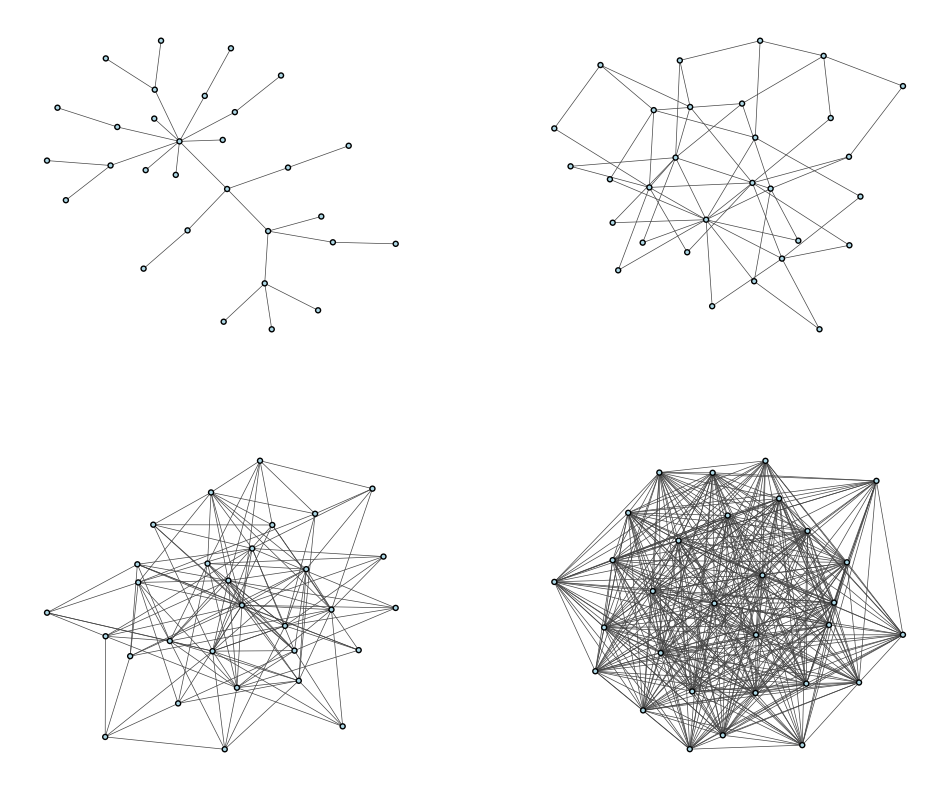

In [7]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
ig.plot(
    g1,
    target=axs[0, 0],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5, 
    edge_width = 0.5
)

ig.plot(
    g2,
    target=axs[0, 1],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5,
    edge_width = 0.5
)

ig.plot(
    g3,
    target=axs[1, 0],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5, 
    edge_width = 0.5
)
ig.plot(
    g4,
    target=axs[1, 1],
    #layout="circle",
    vertex_color="lightblue", 
    vertex_size = 5, 
    edge_width = 0.5
)

Next I have prepared a widget that allows generates graphs using the Barabasi algorithm. On the left is the generated graph and on the right is the degree distribution. Note that in the case we plot the degree distribution on a log-log scale. On this scale a power law relationship is represented as a straight line. Shown on the degree distributon plot is a fitted power law function and the reported $\gamma$ value. 

In [8]:
import ipywidgets as widgets

def update_graph(num_nodes, num_edges):
    g = ig.Graph.Barabasi(num_nodes, num_edges)
    degrees = np.array(g.degree())
    degree_counts = np.bincount(degrees)

    # Prepare data for fitting the power-law
    non_zero_degrees = np.arange(len(degree_counts))[degree_counts > 0]
    log_degrees = np.log(non_zero_degrees)
    log_counts = np.log(degree_counts[degree_counts > 0])

    # Fit the power-law using scipy.stats
    slope, intercept, _, _, _ = sp.stats.linregress(log_degrees, log_counts)

    # Plot the results
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 10)
    
    ig.plot(g, target=axs[0], vertex_size=5, edgewidth = 0.15,  layout='kk', vertex_color="lightblue")
    plt.title("Barabasi-Albert Model")
    
    
    plt.loglog(non_zero_degrees, degree_counts[degree_counts > 0], marker='o', linestyle='None', label='Empirical Data')
    plt.loglog(non_zero_degrees, np.exp(intercept) * non_zero_degrees ** slope, 
               color='b', linestyle='--', label='Fitted Power-law')
    plt.title(f'Degree Distribution with Power-law Fit, gamma: {-slope:.2f}')
    plt.xlabel('Degree (k)')
    plt.ylabel('Count P(k)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create sliders for parameters
num_nodes_slider = widgets.IntSlider(value=5, min=5, max=150, step=10, description='Number of Nodes:')
num_edges_slider = widgets.IntSlider(value=1, min=1, max=10, step=1, description='Edges per Node:')

# Link the update function to the sliders
widgets.interactive(update_graph, num_nodes=num_nodes_slider, num_edges=num_edges_slider)


interactive(children=(IntSlider(value=5, description='Number of Nodes:', max=150, min=5, step=10), IntSlider(v…

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. Describe the relationship between the wellness of fit of the power-law function and number of nodes in the network? 
    
    
2. Describe the relationhsip between the wellness of fit of the power-law function and the number sampling number (m) in the network? 
    
    
3. Compare and contrast the differences between graphs generated by the Barabasi algorithm and the erdos renyi algorithm? 
</div>    

### Investigating a gene regulatory network for a fungal species (A. fumigatus)

Now we will look at a real network, that was generated using gene regulatory network (GRN) inference algorithm called MERLIN-p. The MERLIN-p algorithm takes in a set of bulk RNA-seq data and infers a gene regulatory network. We will not cover the details of the model here but a reference to the paper can be found below:

Alireza F. Siahpirani, Sushmita Roy, A prior-based integrative framework for functional transcriptional regulatory network inference, Nucleic Acids Research, Volume 45, Issue 4, 28 February 2017, Page e21, https://doi.org/10.1093/nar/gkw963

In a recent study, I have applied MERLIN-p-tfa to a collection of publically available Aspergillus Fumigatus RNA-seq data to a infer a gene regulatory network. We will now take some time to investigate properties of the inferred network. A detailed description of the inferred network and its properties can be found in the bioRxiv below: 

Cristobal Carrera Carriel, Saptarshi Pyne, Spencer A. Halberg-Spencer, et al.,A network-based model of Aspergillus fumigatus elucidates regulators of development and defensive natural products of an opportunistic pathogen bioRxiv 2023.05.11.538573; doi: https://doi.org/10.1101/2023.05.11.538573

In [9]:
df = pd.read_csv("GRASP_output_net_0_8_sorted.txt", sep= '\t', header=None, names=["source", "target", "weight"])

### We need the graph to have ids which are defined based on integers 
unique_vertices = pd.concat([df['source'], df['target']]).unique()  # Get unique vertex names
vertex_map = {vertex: idx for idx, vertex in enumerate(unique_vertices)}  # Create mapping

# Step 3: Convert source and target columns to their corresponding numeric indices
df['source'] = df['source'].map(vertex_map)
df['target'] = df['target'].map(vertex_map)

### Convert from dataframe to igraph. 
g = ig.Graph.DataFrame(df, directed=True)

g.es['weight'] = df['weight'].tolist()
g.vs["name"] = unique_vertices

In [10]:
g.summary()

'IGRAPH DNW- 5086 6497 -- \n+ attr: name (v), weight (e)'

The inferred GRN has a total of 5086 genes, and 6597 edges. Below is a visualization of the inferred graph and the degree distirbution of the inferred network.  

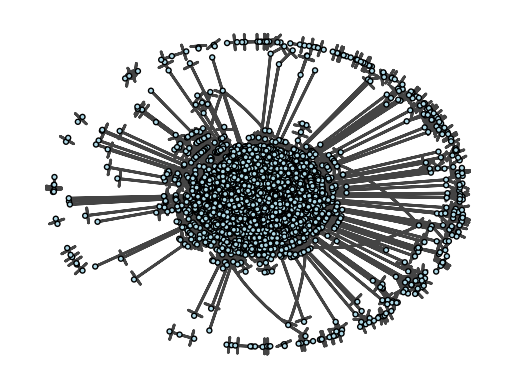

In [26]:
fig.set_size_inches(12, 10) 
fig, ax = plt.subplots()
ig.plot(g, 
        edge_arrow_size=0.5, 
        vertex_size=5, 
        target = ax, 
        edgewidth = 0.15,  
        layout='kk', 
        vertex_color="lightblue")

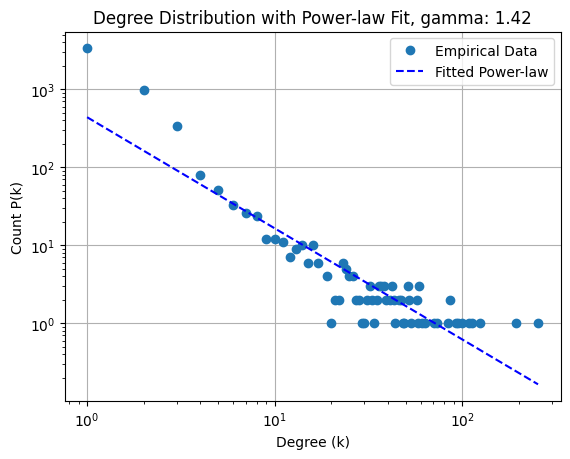

In [13]:
degrees = np.array(g.degree())
degree_counts = np.bincount(degrees)

# Prepare data for fitting the power-law
non_zero_degrees = np.arange(len(degree_counts))[degree_counts > 0]
log_degrees = np.log(non_zero_degrees)
log_counts = np.log(degree_counts[degree_counts > 0])
slope, intercept, _, _, _ = sp.stats.linregress(log_degrees, log_counts)

    
plt.loglog(non_zero_degrees, degree_counts[degree_counts > 0], marker='o', linestyle='None', label='Empirical Data')
plt.loglog(non_zero_degrees, np.exp(intercept) * non_zero_degrees ** slope, 
               color='b', linestyle='--', label='Fitted Power-law')
plt.title(f'Degree Distribution with Power-law Fit, gamma: {-slope:.2f}')
plt.xlabel('Degree (k)')
plt.ylabel('Count P(k)')
plt.grid(True)
plt.legend()
plt.show()

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. Would you describe the inferred GRN as scale-free? 
    
    
2. What does the inferred GRN sturcture tell us about gene regulation? 
     
</div>    

### Module detection in the Karate Club network

Next we will explore community detection in the karate club network. This network is a collection of 34 members from a karate clut at the US univerity in the 1970s. The 78 edges represent relationship between individuals in the karate club. The graph was first cited in this paper: 

W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977).

We will use this netowrk to explore clustering an community detection within graphs. A community is a group of nodes, which have a densely connected sugraphs. How we define which groups of nodes construct our different groups is an unsupervized problem. Different solution may be better in different contexts. 

IGRAPH U--- 34 78 -- 


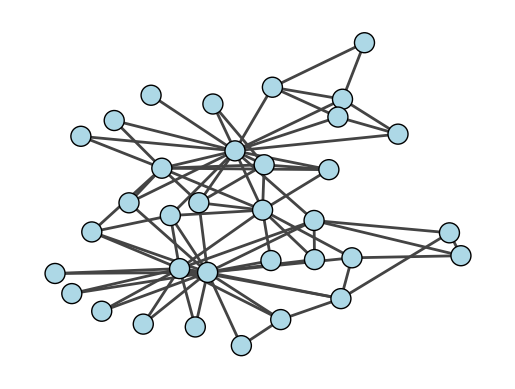

In [25]:
karate = ig.Graph.Famous("Zachary")
print(karate.summary())

layout = karate.layout('kk')

fig, ax = plt.subplots()
ig.plot(karate, 
        vertex_size=20,
        target = ax, 
        layout = layout, 
        edgewidth = 0.15,  
        vertex_color="lightblue")

#### Heirarchical clustering and the Girvan-Newman algorithm

The Girvan-Newman algorithm uses *betweenness* as an indicator of nodes which are central to a network. We can think about betweenness of a measure of necisity for edges or nodes with regards to the set of shortest paths between nodes. *Node betweenness* is the proportion of shortest paths which pass between pairs of nodes that run through it. Similarlly, *edge betweenness* of an edge is the proportion of shortest paths between paris of nodes which run through a specific edge. If there is more than one shortest path, between a pari of nodes, each pair is assigned equally. 

The algorithm performs the following steps: 
1. The betweenness of all edges is network is calculated first.
2. The edges with the hieght betweeness are removed. 
3. The betweeness of all edges affected by the removal is recalculated.
4. Step 2 and three is repeated untill all edgs are removed. 

The algorithm results in a dendrogram, through a top-down approach. The leaves of the dendrogram represent individual nodes, and the inner branches represent community of nodes which are still connected.

In [15]:
def girvan_newman(g):
    # Create a copy of the graph to modify
    graph = g.copy()
    
    #### identify the connected comps
    comps = graph.components()
    num_comps = len(comps)
    palette = ig.RainbowPalette(n=num_comps)
    for i, community in enumerate(comps):
        graph.vs[community]["color"] = i
    
    ### identify edge color 
    edge_betweenness = graph.edge_betweenness()
    max_betweenness = max(edge_betweenness)
    min_betweenness = min(edge_betweenness)
    
    if(len(edge_betweenness) > 0):
        edge_colors = [plt.cm.viridis((eb - min_betweenness) / (max_betweenness - min_betweenness)) for eb in edge_betweenness]
        graph.es["color"] = edge_colors
    
    
    # Store the initial graph object. 
    subgraphs = list()
    copy_graph = graph.copy()
    subgraphs.append(copy_graph)
    
    
    while len(graph.es) > 0 :
        ## Find Edge to remove
        edge_betweenness = graph.edge_betweenness()
        max_betweenness_index = np.argmax(edge_betweenness)
        graph.delete_edges(max_betweenness_index)

        
        
        #### identify the connected comps
        comps = graph.components()
        num_comps = len(comps)
        palette = ig.RainbowPalette(n=num_comps)
        for i, community in enumerate(comps):
            graph.vs[community]["color"] = i
        
        # Recompute edge_betweenness 
        edge_betweenness = graph.edge_betweenness()
     
        # Store the initial graph object.
        if(len(edge_betweenness) > 0): ## Need edges
            max_betweenness = max(edge_betweenness)
            min_betweenness = min(edge_betweenness)
            
            if(max_betweenness - min_betweenness > 0 ):
                edge_colors = [
                    plt.cm.viridis(1 - (eb - min_betweenness) / (max_betweenness - min_betweenness)) for eb in edge_betweenness
                ]
                graph.es["color"] = edge_colors
        
        copy_graph = graph.copy()
        subgraphs.append(copy_graph)
    return subgraphs


def plot_graphs(index):
    subgraph = subgraphs[index]
    n_pal = max(subgraph.vs["color"]) + 1
    palette = ig.RainbowPalette(n=n_pal)
    
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(30, 10)
    
    ig.plot(subgraph,
        edge_color = 'grey', 
        layout = layout,
        target = axs[1],
        palette = palette,
        vertex_label = list(range(subgraph.vcount())),
        vertex_size = 20, 
    )

    ig.plot(subgraph, 
        layout = layout, 
        vertex_color = "grey",
        vertex_size = 20,
        vertex_label = list(range(subgraph.vcount())), 
        target = axs[0])
    
    dendro = karate.community_edge_betweenness(directed=False, clusters = n_pal)
    #clusters = dendro.as_clustering()
    #node_pal = palette[subgraph.vs["color"]]
    ig.plot(dendro, target = axs[2], orientation = "top-bottom")


In [16]:
subgraphs = girvan_newman(karate)

num_edges_slider = widgets.IntSlider(value=0, min=0, max=len(subgraphs)-1, step=1, description='Edges removed')
# Link the update function to the sliders
widgets.interactive(plot_graphs, index=num_edges_slider)

interactive(children=(IntSlider(value=0, description='Edges removed', max=78), Output()), _dom_classes=('widge…

In the above visualzition of the Girvan Newman algorithm we can see how the modules are determined based on the edge betweenness. The first panel, represents the edge betweeness score. Higher values of edge betweenness are indicated by brighter(yellow) colors.  At each interation we remove the edge with the highest betweenness score (in the first case this is edge is the one between 0 and 31). We repeat this process until we a difference in community is detected. After 11, edges are removed, we have two subcomponents which designate are first clustering split in the dendrogram. This process is repeated until all edges are removed and all nodes are assigned to their own clusters. 

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. How might you decide what is the optimal threshold to define clusters? 
    
    
2. In this case, node 9 is its own cluster relatively early. What hight this indicate about node 9's properties?
     
</div>    

#### Louvain and Leiden clustering

An alternative to hierarchical clustering is Louvain and Leiden clustering. These algorithms utilize a different metric to define optimimal clustering called modularity. While optimizing the modularity of a graph is an NP-hard probelm two algorithms have become the principle greedy approaches that are utilized in cell biology, specifically the Louvain and Leiden algorithms. We will not go into the details of the implementation of these agorithms or their difference but provide a great review for additional reading if interested: 

Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

The metric that is used to optimize these algorithm is defined as modularity and is defined as follows: 

$$ Q = \frac{1}{2m} \sum_{i,j} \left[ A_{i,j} - \frac{{k_i}{k_j}}{2m} \right] \delta(c_i, c_j) $$ 

Here $m$ represents the total sum of the edge weights (or the number of edges in an unweighted, undirected network) $k_i$ represents the degree of node $i$ and $\delta()$ is an indicator which equals 1 if node $i$ is in the same cluster as node $j$. The leiden algorithm is implemented in the igraph framework using the *community_leiden(resolution)*. Increasing the resolution of parameter will increase the number of cluster, i.e. have more resolved communities. 

In [17]:
def plot_leiden_clusters(resolution):
    
    communities = karate.community_leiden(resolution = resolution)
    n_pal = len(communities)
    palette = ig.RainbowPalette(n=n_pal)
    for i, community in enumerate(communities):
        karate.vs[community]["color"] = i
    
    fig, ax = plt.subplots()
    ig.plot(karate,
        edge_color = 'grey', 
        layout = layout,
        palette = palette,
        target = ax, 
        vertex_label = list(range(karate.vcount())),
        vertex_size = 20, 
    )

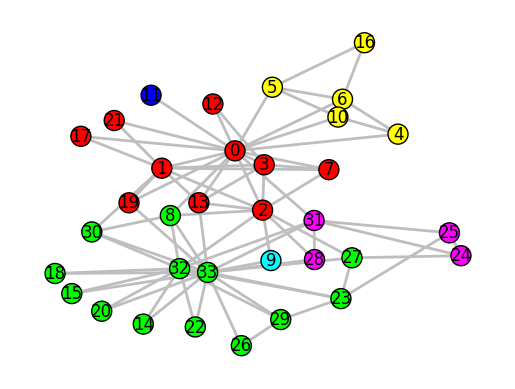

In [18]:
plot_leiden_clusters(0.1)

In [20]:
resolution_slider = widgets.FloatSlider(value=0.01, min=0.01, max=2.0, step=.01, description='Resolution')
# Link the update function to the sliders
widgets.interactive(plot_leiden_clusters, resolution=resolution_slider)

interactive(children=(FloatSlider(value=0.01, description='Resolution', max=2.0, min=0.01, step=0.01), Output(…

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. How does resolution change the clustering result? 

2. What are the similarities between the results of the Girvan-Newman algorithm clusters and the Lieden clustering results. 
    
3. What might be a benefit of using an alogorithm which doesn't depend on recalculating the betweenness feature at every update? 
     
</div>    

#### Spectral clustering

The final algorithm that we will explore is spectral clustering. Spectral clustering utilizes the the graph Lapliacian to cluster the graph. 

The standard graph laplacian is defined as: 

$$ L = D - A $$ 

Where $L$ represent the laplacian, $D$ represents a diagnonal matrix where each element diagonal element of the matrix represents the degree of the node, and $A$ represents the adjacency matrix of the graph. This matrix captures intrinsic properties of the graph which can be used to cluster the nodes. 

The steps of the spectral clustering algorithm are as follows: 
1. Define the laplacian matrix (or normalized laplacian). 
2. Compute the eigenvector representation of the laplacian. 
3. Select the first k, eigenvectors, 
4. cluster the data based on these eigen values. 

The algorithm is implemented below.

In [21]:
def spectral_clustering(graph, clusters, normalized = False): 
    ## find the laplacian matrix
    laplacian = graph.laplacian(normalized = normalized)
    eig_vals, eig_vects = np.linalg.eigh(laplacian) ## we can use eigh for symetric graphs and its faster! 
    best_eigens = [ i for i in range(clusters)]
    LX = eig_vects[:,best_eigens]  ## select these eign vectors  
    ## Normalize the eig vect rowwise. 
    LX = (LX.T / np.linalg.norm(LX, axis=1)).T
    
    ## Cluster with kmeans 
    km = KMeans(n_clusters=clusters, n_init=20)
    km.fit(LX)
    y_pred = km.labels_
    graph.vs["color"] = y_pred
    
def plot_sectral_clusters(k):
    ## Perform Spectral clustering on karate
    spectral_clustering(karate, k)
    
    palette = ig.RainbowPalette(k)
    fig, ax = plt.subplots()
    ig.plot(karate,
        edge_color = 'grey', 
        layout = layout,
        palette = palette,
        target = ax, 
        vertex_label = list(range(karate.vcount())),
        vertex_size = 20, 
    ) 

In [22]:
k_slider = widgets.IntSlider(value=2, min=2, max=33, step=1, description='K')
# Link the update function to the sliders
widgets.interactive(plot_sectral_clusters, k=k_slider)

interactive(children=(IntSlider(value=2, description='K', max=33, min=2), Output()), _dom_classes=('widget-int…

In [23]:
def plot_sectral_clusters(k):
    ## Perform Spectral clustering on karate
    spectral_clustering(karate, k, normalized = True)
    
    palette = ig.RainbowPalette(k)
    fig, ax = plt.subplots()
    ig.plot(karate,
        edge_color = 'grey', 
        layout = layout,
        palette = palette,
        target = ax, 
        vertex_label = list(range(karate.vcount())),
        vertex_size = 20, 
    ) 
    
k_slider = widgets.IntSlider(value=2, min=2, max=33, step=1, description='K')
# Link the update function to the sliders
widgets.interactive(plot_sectral_clusters, k=k_slider)

interactive(children=(IntSlider(value=2, description='K', max=33, min=2), Output()), _dom_classes=('widget-int…

<div style="background-color: lightblue; padding: 10px;">

#### Questions
    
1. Which K do you think best relects the structure in the karate club graph? 

2. How does the normalized laplacian (buttom) spectral clustering differ from the standard spectral (top) clustering? 

3. Which of the three clustering algorithms do you think works best on the carate club graph? Why? 
</div>    

<div style="background-color: lightgreen; padding: 10px;">

#### Challenge
    
In the space of the notebook below, select on of the three clustering algorithms implemented above and explore clustering on the large biological network. As you work consider the following:  

1. How are you defining what clusterings are "good" clustering of the network? 

    
2. How do you determine the correct number of clusters within the data?

    
3. Why might groups of genes be organized into clusters with a GRN? 

    
4. How might you evaualate if these clusters of genes contain biologically meaningful information? 

</div>    